In [18]:
import matplotlib.pyplot as plt
import numpy as np # used only for seed
%matplotlib inline

In [19]:
from engine import Value

In [20]:
# for reproducibility, need to set the seed
np.random.seed(42)

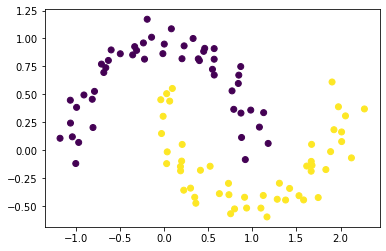

In [21]:
# make a dataset
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise = 0.1)
first_feature = X[:, 0]
second_feature = X[:, 1]

# because we are using a loss function called hinge loss that works values that are either -1 or 1,
# we need to change 0 to -1 for our classes.

y = y*2 - 1

plt.scatter(first_feature, second_feature, c=y)

In [22]:
# Create a small NN library from our littlegrad engine
import random

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
    
    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer(Module):
    def __init__(self, n_in, n_out):
        # create n_out nuerons that take the same n_in inputs
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [parameter for neuron in self.neurons for parameter in neuron.parameters()]

class MLP(Module):
    def __init__(self, n_in, n_outs):
        # creates a list of the size of all layers, including the input layer
        size = [n_in] + n_outs
        self.layers = [Layer(size[i], size[i + 1]) for i in range(len(n_outs))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [parameter for layer in self.layers for parameter in layer.parameters()]

In [23]:
# initialize a small classification model
model = MLP(2, [32, 16, 1])
print("This neural net has", len(model.parameters()), "parameters.")

This neural net has 641 parameters.


In [24]:
def loss():
    # map() applies a given function to each item of a given iterable
    # and returns an iterator of the results
    # this basically make the data in each sample into a Value object, so each row is a row of Value objects.
    inputs = [list(map(Value, xrow)) for xrow in X]

    # forward pass thru the model
    # apply model to each sample, then cast to a list
    classes = list(map(model, inputs))

    # svm hinge loss
    # if belongs to class -1, but outputs 1: loss will be 2; if right: loss will be 0.
    # if belongs to class 1, but outputs -1: loss will also be 2; if right: loss will be 0.
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(y, classes)]

    data_loss = sum(losses) * (1.0 / len(losses))

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(y, classes)]

    return data_loss, sum(accuracy) / len(accuracy)

loss()

(Value(data=1.230864864498866), 0.38)

In [25]:
# optimization
for epoch in range(50):
    
    # forward
    data_loss, acc = loss()
    
    # backward
    model.zero_grad()
    data_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*epoch/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if epoch % 1 == 0:
        print(f"step {epoch} loss {data_loss.data}, accuracy {acc*100}%")

step 0 loss 1.230864864498866, accuracy 38.0%
step 1 loss 0.8565091363282654, accuracy 50.0%
step 2 loss 0.5792892795295584, accuracy 71.0%
step 3 loss 0.46118874857668046, accuracy 77.0%
step 4 loss 0.3818781940558529, accuracy 82.0%
step 5 loss 0.32487930237307466, accuracy 85.0%
step 6 loss 0.2834382586193192, accuracy 87.0%
step 7 loss 0.25817742815003636, accuracy 89.0%
step 8 loss 0.2502434419278918, accuracy 89.0%
step 9 loss 0.2614579705734542, accuracy 87.0%
step 10 loss 0.24238174437122706, accuracy 90.0%
step 11 loss 0.265567478551585, accuracy 87.0%
step 12 loss 0.2238293379631289, accuracy 89.0%
step 13 loss 0.21930863143847695, accuracy 90.0%
step 14 loss 0.21499936331425423, accuracy 89.0%
step 15 loss 0.21036954004682606, accuracy 90.0%
step 16 loss 0.2057584010356515, accuracy 91.0%
step 17 loss 0.20082593187097478, accuracy 90.0%
step 18 loss 0.19601511481446618, accuracy 92.0%
step 19 loss 0.19145450281026485, accuracy 91.0%
step 20 loss 0.19011693467816793, accuracy

In [30]:
# visualization of the decision boundary
h = 0.25
# gets min and max of each variable and add 1 for some extra space to plot
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x_min, x_max

(-2.1751967779895254, 3.2701838184722294)

(-1.5978882018302847, 2.1521117981697153)

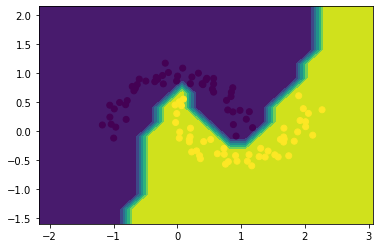

In [42]:
# creates a grid filled in by values in arguments
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# flattens xx and yy and concatenates them along the second axis, columns.
Xmesh = np.c_[xx.ravel(), yy.ravel()]

# cast each value of data to a Value object
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
# run each row thru the model
scores = list(map(model, inputs))

# Z for levels of contour plot
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())